# QKSAN: A Quantum Kernel Self-Attention Network

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import pandas as pd
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.utils import shuffle

%matplotlib inline


In [2]:
n_features = 8
n_qubits = 4
n_qubits_per_ansatz = 2
n_params_per_ansatz = (2 * n_qubits_per_ansatz)-1
n_params = 11
batch_size = 30
n_samples = 550
n_test_samples = 50
n_layers = 6
lr = 0.09

In [3]:
dev = qml.device("default.qubit", wires=n_qubits)

def statepreparation(x,wires):
    qml.QubitUnitary(x,wires)

def HEAnsatz(weights,wires,n_layers):
    for layer in range(n_layers):
        i=0
        for wire in wires: 
            qml.Hadamard(wires=wire)
            qml.RZ(phi=weights[i],wires = wire)
            i+=1        for wire in wires:
            qml.CRY(phi=weights[i],wires = [wire,(wire+1)%len(wires)])
            i+=1
def QAOAAnsatz(weights,wires,n_layers):
    for layer in range(n_layers):
        i=0
        for wire in wires: 
            qml.Hadamard(wires=wire)
            qml.RY(phi=weights[i],wires = wire)
        for wire in wires:
            qml.CNOT(wires = [wire,(wire+1)%len(wires)])
            qml.RZ(phi=weights[i],wires = [wire])
            qml.CNOT(wires = [wire,(wire+1)%len(wires)])
            
@qml.qnode(dev)
def circuit(weights,x_1,x_2):
    statepreparation(x_1,wires = range(n_qubits_per_ansatz))
    HEAnsatz(weights=weights[:n_params_per_ansatz] ,wires=range(n_qubits_per_ansatz) ,n_layers = n_layers)

    statepreparation(x_2,wires = range(n_qubits_per_ansatz))
    qml.adjoint(HEAnsatz)(weights=weights[n_params_per_ansatz:2*n_params_per_ansatz] ,wires=range(n_qubits_per_ansatz) ,n_layers = n_layers)

    statepreparation(x_2,wires = range(n_qubits_per_ansatz,2*n_qubits_per_ansatz))
    HEAnsatz(weights=weights[2*n_params_per_ansatz:3*n_params_per_ansatz] ,wires=range(n_qubits_per_ansatz,2*n_qubits_per_ansatz) ,n_layers = n_layers)

    measures = [qml.measure(i) for i in range(n_qubits_per_ansatz)]

    for wire in range(n_qubits_per_ansatz):
        qml.cond(measures[wire],qml.RY)(weights[n_params-wire-1],wires=n_qubits_per_ansatz + wire)
        
    return qml.probs(wires=[n_qubits-1])    

def loss(labels,predictions):
    tot_loss = 0
    for l,p in zip(labels,predictions):
        tot_loss += (l-p)**2
    return tot_loss/len(predictions)

def get_unitary_amp_embed(feature,n_qubits,adjoint = False):
    if adjoint:
        return qml.matrix(qml.adjoint(qml.AmplitudeEmbedding(features=feature, wires=range(n_qubits),normalize=True)))
    else:
        return qml.matrix(qml.AmplitudeEmbedding(features=feature, wires=range(n_qubits),normalize=True))

def cost(weights, X, Y):
    predictions = [circuit(weights, get_unitary_amp_embed(x[:4],2),get_unitary_amp_embed(x[4:],2,adjoint = True))[0] for x in X]
    return loss(Y, predictions)

def accuracy(labels, predictions):

    tot_loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            tot_loss += 1
    tot_loss  /= len(labels)

    return tot_loss

In [4]:
mnist = fetch_openml('mnist_784')

pca = PCA(n_components=n_features)
scaler = StandardScaler()

y_0 = mnist.target[(mnist.target == '0')].sample(n=n_samples, random_state=1)
y_1 = mnist.target[(mnist.target == '1')].sample(n=n_samples, random_state=1)

X_0 = mnist.data.iloc[y_0]
X_1 = mnist.data.iloc[y_1]

y_0 = y_0.to_numpy(dtype=np.int_)
y_1 = y_1.to_numpy(dtype=np.int_)

X_train = np.concatenate((X_0[:n_samples-n_test_samples],X_1[:n_samples-n_test_samples]))
y_train = np.concatenate((y_0[:n_samples-n_test_samples],y_1[:n_samples-n_test_samples]))
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_test = np.concatenate((X_0[-n_test_samples:],X_1[-n_test_samples:]))
y_test = np.concatenate((y_0[-n_test_samples:],y_1[-n_test_samples:]))
X_test, y_test = shuffle(X_test, y_test, random_state=1)

X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

/home/poojithurao/miniconda3/envs/qiskit/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
weights = np.random.randn(n_params, requires_grad=True)
opt = NesterovMomentumOptimizer(lr)


In [6]:
accuracy_list = []
cost_list = []
for it in range(120):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]
    weights, _, _ = opt.step(cost, weights, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.rint(circuit(weights, get_unitary_amp_embed(x[:4],2),get_unitary_amp_embed(x[4:],2,adjoint = True))[0]) for x in X_train]
    accuracy_list.append(accuracy(y_train, predictions))
    cost_list.append(cost(weights, X_train, y_train))
    if it%10 == 0:
        print(
            "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(it + 1, cost_list[-1] , accuracy_list[-1]    )
        )

Iter:     1 | Cost: 0.3098034 | Accuracy: 0.4980000 
Iter:    11 | Cost: 0.1405104 | Accuracy: 0.9870000 
Iter:    21 | Cost: 0.1116589 | Accuracy: 0.9930000 
Iter:    31 | Cost: 0.1142952 | Accuracy: 0.9930000 
Iter:    41 | Cost: 0.1129545 | Accuracy: 0.9930000 
Iter:    51 | Cost: 0.1118168 | Accuracy: 0.9930000 
Iter:    61 | Cost: 0.1121662 | Accuracy: 0.9920000 
Iter:    71 | Cost: 0.1120027 | Accuracy: 0.9930000 
Iter:    81 | Cost: 0.1129731 | Accuracy: 0.9920000 
Iter:    91 | Cost: 0.1119163 | Accuracy: 0.9920000 
Iter:   101 | Cost: 0.1123493 | Accuracy: 0.9930000 
Iter:   111 | Cost: 0.1141438 | Accuracy: 0.9920000 


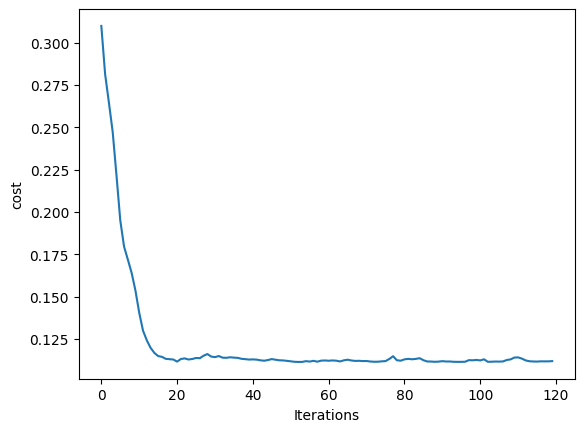

In [7]:
plt.plot(cost_list)
plt.xlabel("Iterations")
plt.ylabel("cost")
plt.show()

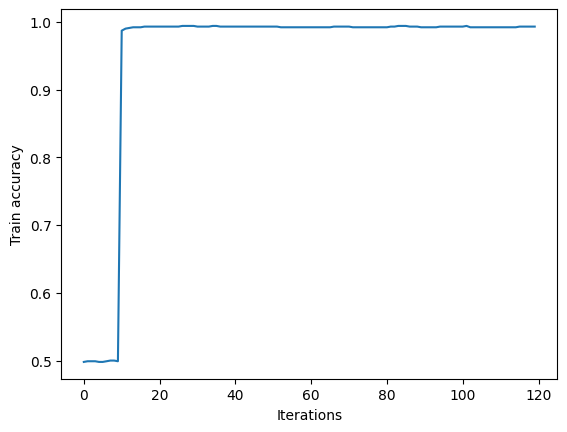

In [8]:
plt.plot(accuracy_list)
plt.xlabel("Iterations")
plt.ylabel("Train accuracy")
plt.show()

In [9]:
predictions = [np.rint(circuit(weights, get_unitary_amp_embed(x[:4],2),get_unitary_amp_embed(x[4:],2,adjoint = True))[0]) for x in X_test]
acc = accuracy(y_test, predictions)

print("Test Accuracy: {:0.7f} ".format(acc))

Test Accuracy: 0.9600000 
